In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats

import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.metrics import r2_score
from sklearn import linear_model
import seaborn as sns

from sklearn import decomposition as decomp
from sklearn import preprocessing as prep
from sklearn import manifold as mfold

# READ CSV

In [2]:
iniN = 3
endN = 52

src = '../hpcc/traditional/'
dst = '../../writing/walnut_figs/'
perbasis = 'individual'

filename = src + 'traditional_phenotype_summary.csv'
df = pd.read_csv(filename, dtype={1:str})
print(df.shape)
endN = df.shape[1]
df.head()

(1264, 52)


UCACCSD          bname  wname  nut_length  nut_height  nut_width  \
0  06-005-27  2008SB_R4_T13      1   41.750477   33.582913  31.395051   
1  06-005-27  2008SB_R4_T13      2   39.720443   33.450554  31.454860   
2  06-005-27  2008SB_R4_T13      3   42.790987   35.768852  33.257804   
3  06-005-27  2008SB_R4_T13      4   39.589858   34.400643  31.931823   
4  06-005-27  2008SB_R4_T13      5   38.284326   34.049830  31.365337   

        nut_vol  nut_va3d  nut_ratio_feret     nut_area  ...  \
0  20387.149371  4.941865         1.329843  6147.314265  ...   
1  20512.900734  4.643222         1.262776  6045.635968  ...   
2  24394.576769  4.596968         1.286645  6763.478980  ...   
3  21020.676969  4.496373         1.239825  6079.521052  ...   
4  19995.849647  4.335537         1.220594  5809.316020  ...   

   meat_ratio_cavity_area  meat_ratio_cavity_vol   rho_mvs   rho_vvs  \
0                0.034601               0.031335  0.840804  0.592775   
1                0.033174               0.029986  0.846395  0.587884   
2                0.040115               0.037996  0.837089  0.598603   
3                0.031933               0.029688  0.840064  0.602599   
4                0.032905               0.032489  0.825360  0.586143   

    rho_vvm  meat_ratio_feret    nut_vol_sa  meat_ratio_vol_sa  \
0  0.705009          1.526275  12880.783084           0.463951   
1  0.694574          1.425155  13706.563584           0.469242   
2  0.715100          1.486324  15546.904008           0.465462   
3  0.717325          1.411052  14347.815998           0.482360   
4  0.710167          1.314016  12806.076196           0.475517   

   vein_ratio_vol_sa  shell_ratio_vol_sa  
0           0.195673            0.340377  
1           0.207626            0.323132  
2           0.203646            0.330892  
3           0.211936            0.305704  
4           0.186909            0.337574  

[5 rows x 52 columns]

In [3]:
filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)
labels.head()

(67, 2)


col_labels col_units
0     UCACCSD          
1  Batch Name          
2   Scan Name          
3  Nut Length      [mm]
4  Nut Height      [mm]

In [4]:
evalf = df.iloc[:,iniN:].describe().T.drop(columns=['count'])
evalf.index = labels.col_labels.iloc[iniN:endN].values
qcd = (evalf['75%'] - evalf['25%'])/(evalf['75%'] + evalf['25%'])
cv = evalf['std']/evalf['mean']
qdist = evalf['75%']/evalf['25%']
evalf['QCD'] = qcd
evalf['CV'] = cv

evalf['Units'] = labels.col_units.iloc[iniN:endN].values

filename = src + 'traditional_phenotype_variance_' + perbasis +'.csv'
print(filename)
evalf = evalf.loc[:,evalf.columns[[9,0,1,2,6,3,5,8,7]]].sort_values('QCD')
evalf.to_csv(filename, index=True, index_label="Phenotype", float_format='%.2f')

../hpcc/traditional/traditional_phenotype_variance_individual.csv


../../writing/walnut_figs/trait_variation_individual


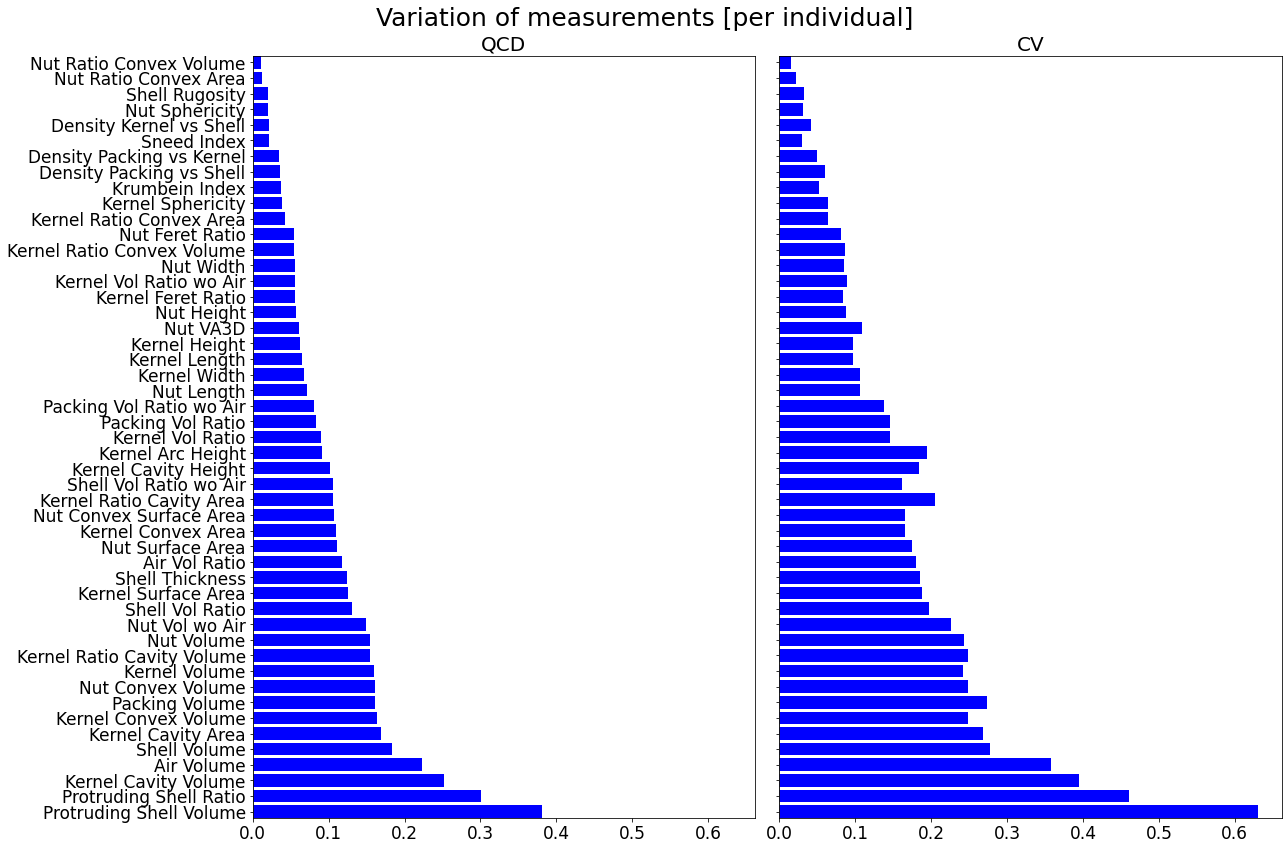

In [5]:
fs = 16
fig, ax = plt.subplots(1,2, figsize=(18,12), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0
sortarr = np.argsort(qcd.values)[::-1]
titles = ['QCD', 'CV']
xlocator = ticker.MaxNLocator(nbins=10, steps=np.arange(1,10))
xlocator = ticker.MultipleLocator(base=0.1)

for idx,vals in enumerate([qcd.values, cv.values]):

    ax[idx].barh(range(len(vals)), vals[sortarr], color='b')
    ax[idx].axvline(0, c='gray')
    ax[idx].set_yticks(range(len(vals)))
    ax[idx].set_yticklabels(labels.col_labels.iloc[iniN + sortarr].values);
    ax[idx].tick_params(labelrotation=0, labelsize=fs+1);
    ax[idx].xaxis.set_major_locator(xlocator)
    ax[idx].margins(y=0)
    ax[idx].set_title(titles[idx], fontsize=20)

fig.suptitle('Variation of measurements [per '+perbasis+']', fontsize=25)
fig.tight_layout();

filename = dst + 'trait_variation_' + perbasis
print(filename)
plt.savefig(filename + '.pdf', dpi=200, format='pdf', bbox_inches='tight')
#plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight')

In [6]:
rng = np.random.default_rng()
mmtraits = np.asarray(list(range(3,7)) + [9] + [11,12] + [17,18,19,20] + [26] + list(range(28,35)) + list(range(37,41)) + [48])
filename = src + 'traditional_log_R2_' +perbasis+'.csv'

ols_m = np.ones((len(mmtraits), len(mmtraits)))
ols_b = ols_m.copy()
ols_r = ols_m.copy()
ols_p = ols_m.copy()
ols_R2 = ols_m.copy()

if os.path.isfile(filename):
    foo = np.loadtxt(filename, delimiter=',')
    ols_m = foo[:len(ols_m)]
    ols_b = foo[len(ols_m):2*len(ols_m)]
    ols_p = foo[2*len(ols_m):3*len(ols_m)]
    ols_r = foo[3*len(ols_m):4*len(ols_m)]
    ols_R2= foo[4*len(ols_m):]
else:
    BB = 1000
    bootstrap = np.zeros((BB,5))

    for i in range(len(ols_m)):
        for j in range(len(ols_m)):        
            nonzero_i = set(np.nonzero(df.iloc[:,mmtraits[i]].values)[0])
            nonzero_j = set(np.nonzero(df.iloc[:,mmtraits[j]].values)[0])

            nonzero = np.asarray(list(nonzero_i & nonzero_j))

            trait_i = np.log(df.iloc[nonzero,mmtraits[i]].values)
            trait_j = np.log(df.iloc[nonzero,mmtraits[j]].values)

            for k in range(BB):
                bb = rng.choice(len(trait_i), len(trait_i))
                ti = trait_i[bb]
                tj = trait_j[bb]

                ols = stats.linregress(ti, tj)

                bootstrap[k] = [ols.slope, 
                                ols.intercept, 
                                ols.pvalue, 
                                ols.rvalue, 
                                r2_score(tj, ols.slope*ti + ols.intercept)]

            bmeans = np.mean(bootstrap, axis = 0)

            ols_m[i, j] = bmeans[0]
            ols_b[i, j] = bmeans[1]
            ols_p[i, j] = bmeans[2]
            ols_r[i, j] = bmeans[3]
            ols_R2[i,j] = bmeans[4]
            
    np.savetxt(filename, np.vstack((ols_m, ols_b, ols_p, ols_r, ols_R2)), delimiter=',')

In [7]:
foo = pd.DataFrame(ols_R2, columns=labels.col_labels.iloc[mmtraits], index=labels.col_labels.iloc[mmtraits])
foo
#foo['Kernel Volume'].sort_values(ascending=False)

col_labels               Nut Length  Nut Height  Nut Width  Nut Volume  \
col_labels                                                               
Nut Length                 1.000000    0.336616   0.406834    0.615200   
Nut Height                 0.337276    1.000000   0.759264    0.859774   
Nut Width                  0.406830    0.759702   1.000000    0.862746   
Nut Volume                 0.614277    0.859790   0.862503    1.000000   
Nut Surface Area           0.643176    0.829706   0.856563    0.968878   
Nut Convex Surface Area    0.653369    0.844975   0.859586    0.992938   
Nut Convex Volume          0.625639    0.858830   0.871674    0.996481   
Air Volume                 0.397401    0.657907   0.620283    0.741509   
Kernel Volume              0.394989    0.548607   0.593397    0.647792   
Shell Volume               0.435471    0.437722   0.454003    0.521501   
Packing Volume             0.474662    0.617155   0.630058    0.723284   
Shell Thickness            0.061935    0.024496   0.024858    0.030281   
Protruding Shell Volume    0.099806    0.068189   0.104957    0.099895   
Kernel Length              0.725602    0.294541   0.367088    0.543619   
Kernel Height              0.271630    0.866263   0.642067    0.730513   
Kernel Width               0.209064    0.582068   0.744690    0.626578   
Kernel Surface Area        0.452788    0.564208   0.612760    0.688545   
Kernel Convex Volume       0.491758    0.746328   0.767205    0.858670   
Kernel Convex Area         0.524408    0.750764   0.768919    0.875711   
Kernel Cavity Area         0.400361    0.324517   0.392748    0.479537   
Kernel Cavity Volume       0.290411    0.425272   0.479021    0.519696   
Kernel Arc Height          0.039109    0.018465   0.014245    0.021208   
Kernel Cavity Height       0.325551    0.065292   0.114871    0.184755   
Nut Vol wo Air             0.535418    0.675734   0.712646    0.797679   

col_labels               Nut Surface Area  Nut Convex Surface Area  \
col_labels                                                           
Nut Length                       0.643326                 0.652691   
Nut Height                       0.829310                 0.844958   
Nut Width                        0.856703                 0.859158   
Nut Volume                       0.968732                 0.992953   
Nut Surface Area                 1.000000                 0.984817   
Nut Convex Surface Area          0.984764                 1.000000   
Nut Convex Volume                0.982551                 0.998572   
Air Volume                       0.724930                 0.736438   
Kernel Volume                    0.600769                 0.628680   
Shell Volume                     0.533546                 0.537148   
Packing Volume                   0.701558                 0.719019   
Shell Thickness                  0.034124                 0.033750   
Protruding Shell Volume          0.121897                 0.108388   
Kernel Length                    0.524239                 0.551091   
Kernel Height                    0.684264                 0.707394   
Kernel Width                     0.606263                 0.607471   
Kernel Surface Area              0.648044                 0.671257   
Kernel Convex Volume             0.809966                 0.841000   
Kernel Convex Area               0.830236                 0.861112   
Kernel Cavity Area               0.450369                 0.474232   
Kernel Cavity Volume             0.495548                 0.510409   
Kernel Arc Height                0.025187                 0.024556   
Kernel Cavity Height             0.167712                 0.183150   
Nut Vol wo Air                   0.767868                 0.790205   

col_labels               Nut Convex Volume  Air Volume  Kernel Volume  \
col_labels                                                              
Nut Length                        0.626906    0.396638       0.393949   
Nut Height                        0

In [8]:
for i in range(0,len(mmtraits)):
    print(i,mmtraits[i], labels.col_labels.iloc[mmtraits[i]], labels.col_units.iloc[mmtraits[i]], df.columns[mmtraits[i]],sep='\t')

0	3	Nut Length	 [mm]	nut_length
1	4	Nut Height	 [mm]	nut_height
2	5	Nut Width	 [mm]	nut_width
3	6	Nut Volume	 [mm$^3$]	nut_vol
4	9	Nut Surface Area	 [mm$^2$]	nut_area
5	11	Nut Convex Surface Area	 [mm$^2$]	nut_cnvx_area
6	12	Nut Convex Volume	 [mm$^3$]	nut_cnvx_vol
7	17	Air Volume	 [mm$^3$]	air_vol
8	18	Kernel Volume	 [mm$^3$]	meat_vol
9	19	Shell Volume	 [mm$^3$]	shell_vol
10	20	Packing Volume	 [mm$^3$]	vein_vol
11	26	Shell Thickness	 [mm]	shell_thickness
12	28	Protruding Shell Volume	 [mm$^3$]	shell_prot_vol
13	29	Kernel Length	 [mm]	meat_length
14	30	Kernel Height	 [mm]	meat_height
15	31	Kernel Width	 [mm]	meat_width
16	32	Kernel Surface Area	 [mm$^2$]	meat_area
17	33	Kernel Convex Volume	 [mm$^3$]	meat_cnvx_vol
18	34	Kernel Convex Area	 [mm$^2$]	meat_cnvx_area
19	37	Kernel Cavity Area	 [mm$^2$]	meat_cavity_area
20	38	Kernel Cavity Volume	 [mm$^3$]	meat_cavity_vol
21	39	Kernel Arc Height	 [mm]	meat_arc_height
22	40	Kernel Cavity Height	 [mm]	meat_cavity_height
23	48	Nut Vol wo Air	 [

1933137.3227155663
77.2783840635655
154.556768127131


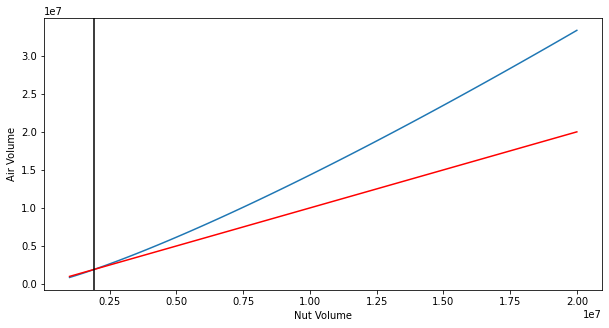

In [126]:
i = 3
j = 7

xrange = np.linspace(1e6, 2e7, 100)
bar = np.exp(-ols_b[i,j]/(ols_m[i,j]-1))
plt.figure(figsize=(10,5))

plt.plot(xrange, np.exp(ols_b[i,j])*np.power(xrange,ols_m[i,j]))
plt.plot(xrange, xrange, c='r');

plt.xlabel(new_col_labels[mmtraits[i]])
plt.ylabel(new_col_labels[mmtraits[j]])

plt.axvline(bar, c='k')
print(bar)
print(np.cbrt(3*bar/(4*np.pi)))
print(2*np.cbrt(3*bar/(4*np.pi)))

../../writing/walnut_figs/nut_volume_allometry_individual_5x4


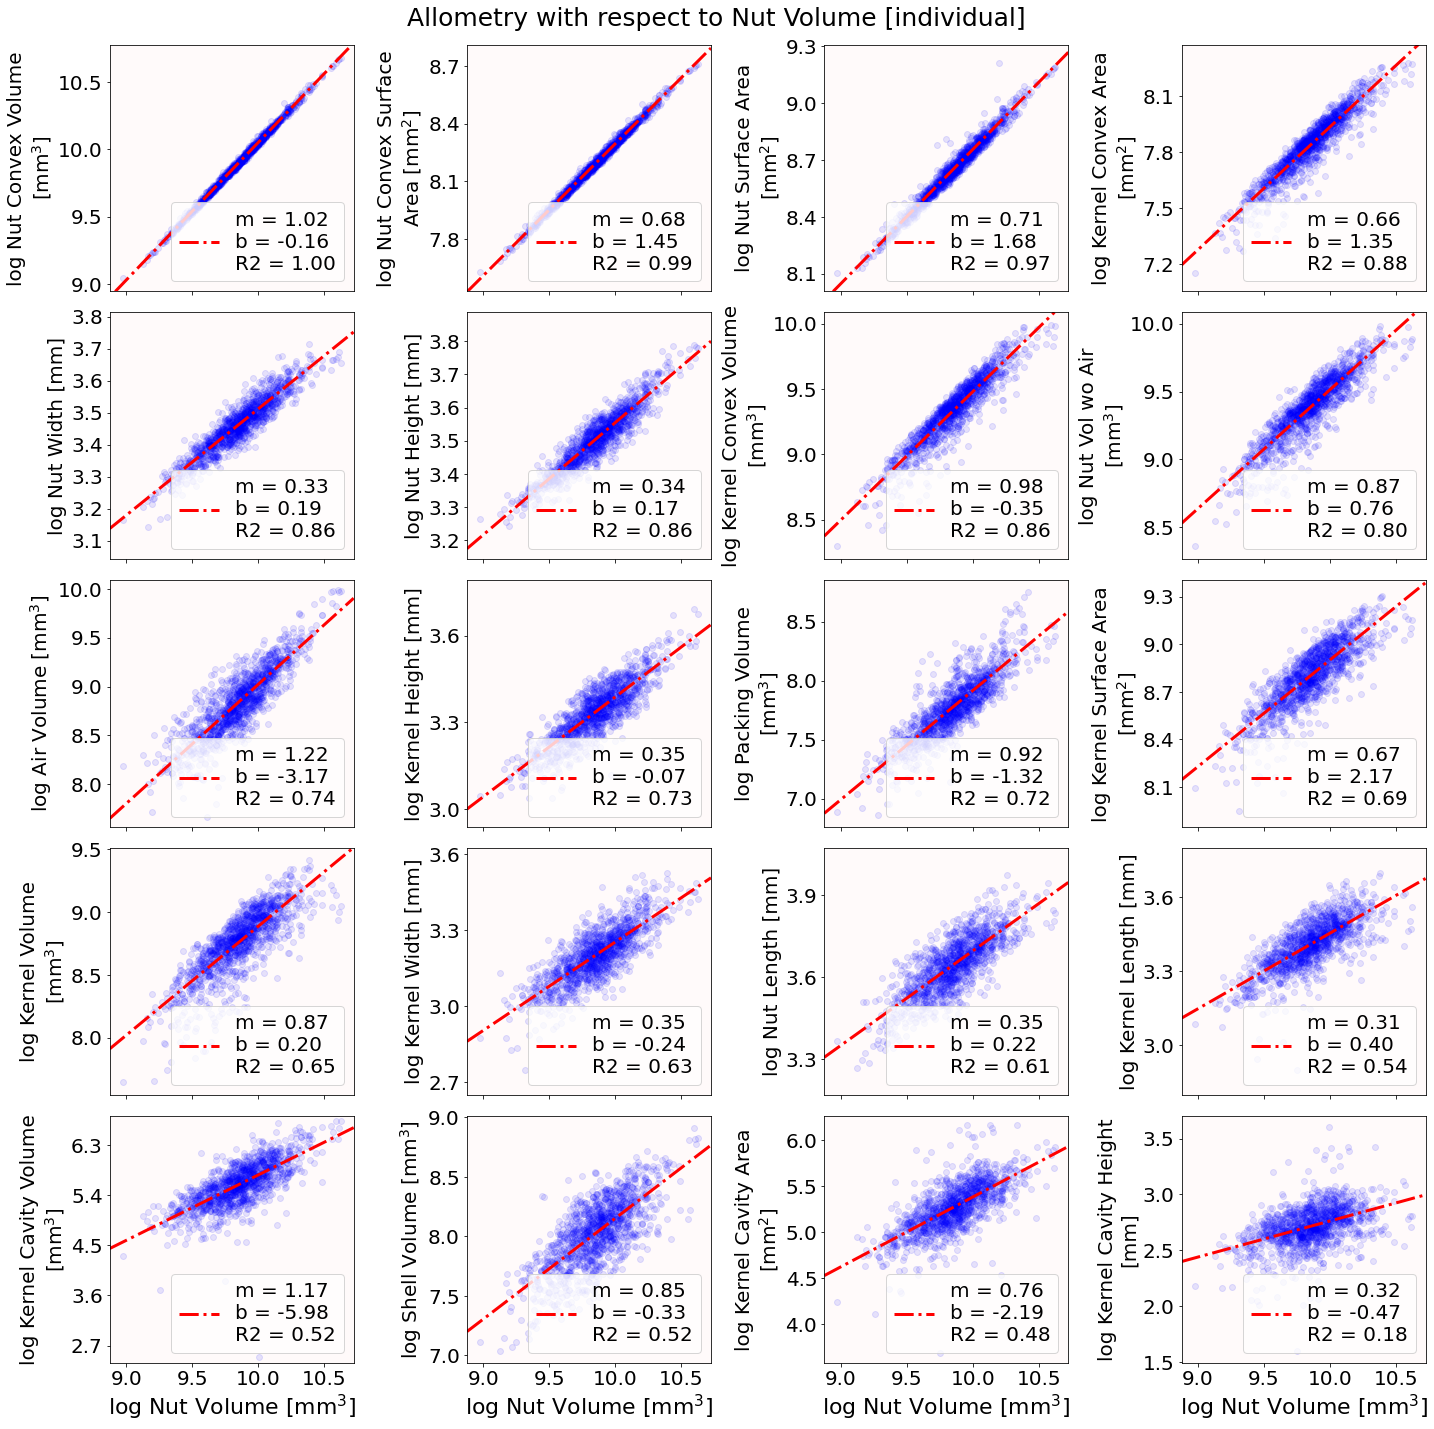

In [11]:
fs = 20
fig, ax = plt.subplots(5,4, figsize=(20,20), sharex=True)
ax = np.atleast_1d(ax).ravel()

i = 3
TRAIT_I = np.log(df.iloc[:,mmtraits[i]].values)
argsort = np.argsort(ols_R2[i])[::-1][1:]

for idx in range(len(ax)):
    j = mmtraits[argsort[idx]]
    nonzero = np.nonzero(df.iloc[:,j].values)[0]
    if len(nonzero) == len(df):
        trait_i = TRAIT_I.copy()
        trait_j = np.log(df.iloc[:,j].values)
    else:
        trait_i = np.log(df.iloc[nonzero,mmtraits[i]].values)
        trait_j = np.log(df.iloc[nonzero,j].values)
        
    ax[idx].set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
    ax[idx].set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
    ax[idx].set_facecolor('snow')
    ax[idx].tick_params(labelsize=fs)
    
    m = ols_m[i,argsort[idx]]
    r2 = ols_R2[i,argsort[idx]]
    b = ols_b[i,argsort[idx]]

    axlabel = 'm = {:.2f}\nb = {:.2f}\nR2 = {:.2f}'.format(m,b,r2)
    bar = ax[idx].axline(xy1=(0,b), slope=m, color='r', label=axlabel, ls='-.', lw=3)

    ax[idx].scatter(trait_i, trait_j, color='b', alpha=0.1)
    ylabel = 'log ' + labels.col_labels.iloc[j] + labels.col_units.iloc[j]
    ax[idx].set_ylabel(textwrap.fill(ylabel,25), fontsize=fs);
    ax[idx].legend(loc='lower right', fontsize=fs)
    
    ylocator = ticker.MaxNLocator(steps=np.arange(1,11,2), nbins=6, min_n_ticks=3)
    ax[idx].yaxis.set_major_locator(ylocator)
    #ax[idx].xaxis.set_major_locator(xlocator)

for idx in range(len(ax)-4,len(ax)):
    ax[idx].set_xlabel('log ' + labels.col_labels.iloc[mmtraits[i]] + labels.col_units.iloc[mmtraits[i]], fontsize=fs+2);

fig.suptitle('Allometry with respect to ' + labels.col_labels.iloc[mmtraits[i]] + ' ['+perbasis+']', fontsize=25, y=.99)
fig.tight_layout()

filename = dst + labels.col_labels.iloc[mmtraits[i]].lower().replace(' ','_') + '_allometry_' +perbasis +'_5x4'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

../hpcc/traditional/results/nut_convex_volume_vs_nut_volume
../hpcc/traditional/results/nut_convex_surface_area_vs_nut_volume


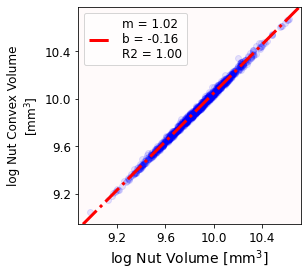

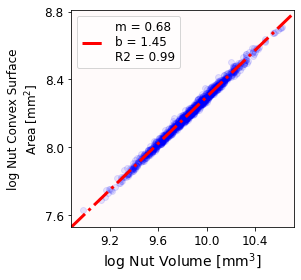

In [71]:
fs = 12
i = 3
TRAIT_I = np.log(df.iloc[:,mmtraits[i]].values)
argsort = np.argsort(ols_R2[i])[::-1][1:]

for idx in range(2):
    fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True)

    j = mmtraits[argsort[idx]]
    nonzero = np.nonzero(df.iloc[:,j].values)[0]
    if len(nonzero) == len(df):
        trait_i = TRAIT_I.copy()
        trait_j = np.log(df.iloc[:,j].values)
    else:
        trait_i = np.log(df.iloc[nonzero,mmtraits[i]].values)
        trait_j = np.log(df.iloc[nonzero,j].values)
        
    ax.set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
    ax.set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
    ax.set_facecolor('snow')
    ax.tick_params(labelsize=fs)
    
    m = ols_m[i,argsort[idx]]
    r2 = ols_R2[i,argsort[idx]]
    b = ols_b[i,argsort[idx]]

    axlabel = 'm = {:.2f}\nb = {:.2f}\nR2 = {:.2f}'.format(m,b,r2)
    bar = ax.axline(xy1=(0,b), slope=m, color='r', label=axlabel, ls='-.', lw=3)

    ax.scatter(trait_i, trait_j, color='b', alpha=0.1)
    ylabel = 'log ' + labels.col_labels.iloc[j] + labels.col_units.iloc[j]
    ax.set_ylabel(textwrap.fill(ylabel,25), fontsize=fs);
    ax.legend(loc='upper left', fontsize=fs)
    ax.set_xlabel('log ' + labels.col_labels.iloc[mmtraits[i]] + labels.col_units.iloc[mmtraits[i]], fontsize=fs+2);
    ax.locator_params('both', nbins=5, steps=[2,4,6,8,10])
    
    filename = dst + labels.col_labels.iloc[j].lower().replace(' ','_') + '_vs_' + labels.col_labels.iloc[mmtraits[i]].lower().replace(' ','_')
    print(filename)
    #plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    #plt.close()

../../writing/walnut_figs/individual_tissue_allometry_individual


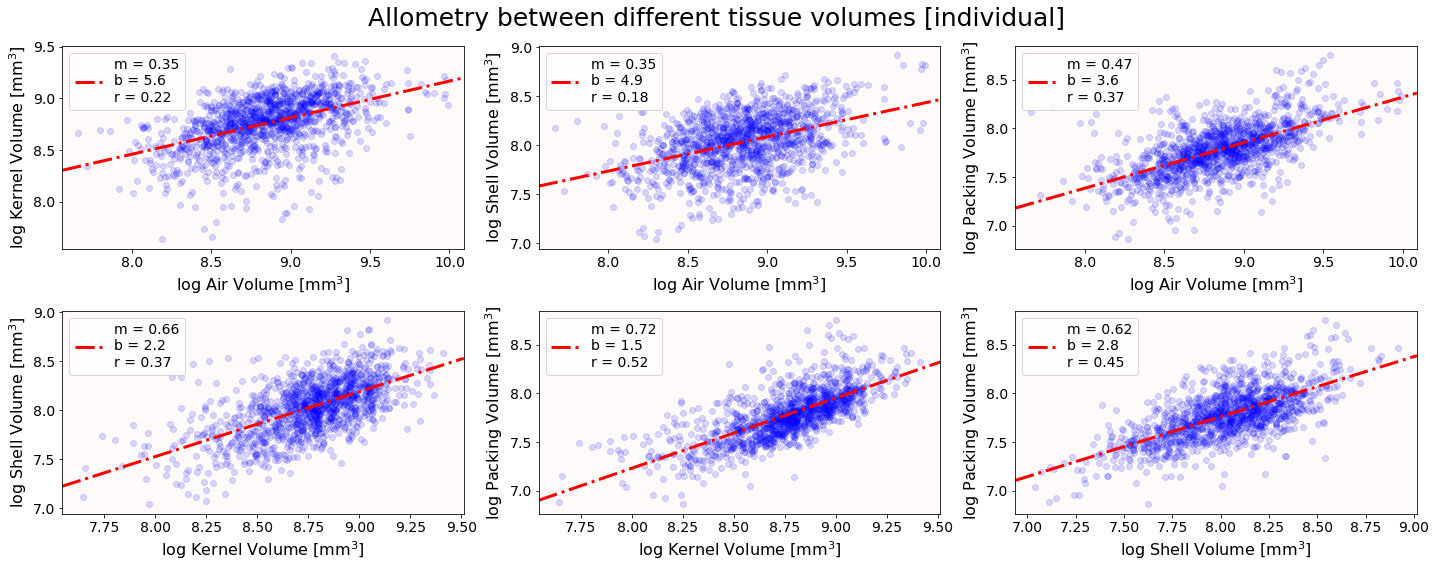

In [12]:
fs = 14
fig, ax = plt.subplots(2,3, figsize=(20,8))
ax = np.atleast_1d(ax).ravel()

idx = 0
for i in range(17,21):
    trait_i = np.log(df.iloc[:,i].values)
    for j in range(i+1, 21):
        trait_j = np.log(df.iloc[:,j].values)
        r,p = stats.pearsonr(trait_i, trait_j)

        ax[idx].set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
        ax[idx].set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
        ax[idx].set_facecolor('snow')
        ax[idx].tick_params(labelsize=fs)

        new_series = P.Polynomial.fit(trait_i,trait_j, deg=1, full=False)
        foo = new_series.convert().coef
        r2 = r2_score(trait_j, new_series(trait_i))
        axlabel = 'm = {:.2}\nb = {:.2}\nr = {:.2}'.format(foo[1], foo[0], r2)
        bar = ax[idx].axline(xy1=(0,foo[0]), slope=foo[1], color='r', label=axlabel, ls='-.', lw=3)

        ax[idx].scatter(trait_i, trait_j, color='b', alpha=0.15)
        ax[idx].set_ylabel('log ' + labels.col_labels.iloc[j] + labels.col_units.iloc[j], fontsize=fs+2);
        ax[idx].set_xlabel('log ' + labels.col_labels.iloc[i] + labels.col_units.iloc[i], fontsize=fs+2);
        ax[idx].legend(loc='upper left', fontsize=fs)
        idx += 1

#for idx in range(10,len(ax)):
#    ax[idx].set_xlabel('log ' + col_labels[i] + col_units[i], fontsize=fs+2);

fig.suptitle('Allometry between different tissue volumes ['+perbasis+']', fontsize=25)
fig.tight_layout()
filename = dst + 'individual_tissue_allometry_' +perbasis
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')

In [35]:
feats = df.iloc[:,iniN:].values.copy()

pcorrstat = np.ones((feats.shape[1], feats.shape[1]))
ppvalcorr = np.zeros_like(pcorrstat)

scorrstat = np.ones((feats.shape[1], feats.shape[1]))
spvalcorr = np.zeros_like(pcorrstat)

for i in range(len(pcorrstat)-1):
    for j in range(i+1, len(pcorrstat)):
        pstat, ppval = stats.pearsonr(feats[:,i], feats[:,j])
        sstat, spval = stats.spearmanr(feats[:,i], feats[:,j])
        
        pcorrstat[i,j] = pstat
        pcorrstat[j,i] = pstat
        ppvalcorr[i,j] = ppval
        ppvalcorr[j,i] = ppval
        
        scorrstat[i,j] = sstat
        scorrstat[j,i] = sstat
        spvalcorr[i,j] = spval
        spvalcorr[j,i] = spval

In [36]:
foo = pd.DataFrame(scorrstat, columns=labels.col_labels.iloc[iniN:endN].values, index=labels.col_labels.iloc[iniN:endN].values)
trait = 'Kernel Vol Ratio wo Air'
args = np.argsort(np.abs(foo[trait].values))[::-1]
foo[trait].iloc[args]

Kernel Vol Ratio wo Air       1.000000
Shell Vol Ratio wo Air       -0.813175
Kernel Vol Ratio              0.672965
Shell Vol Ratio              -0.568465
Shell Thickness              -0.526708
Protruding Shell Volume      -0.422293
Shell Volume                 -0.412496
Kernel Ratio Convex Area     -0.396652
Packing Vol Ratio wo Air     -0.380162
Kernel Ratio Convex Volume    0.377003
Kernel Volume                 0.358649
Density Kernel vs Shell       0.332171
Kernel Surface Area           0.300851
Protruding Shell Ratio       -0.300824
Nut Sphericity                0.262932
Nut VA3D                     -0.262932
Shell Rugosity               -0.262932
Packing Vol Ratio            -0.242842
Kernel Convex Volume          0.231978
Nut Ratio Convex Area         0.221169
Nut Ratio Convex Volume       0.216977
Kernel Ratio Cavity Area     -0.216965
Kernel Convex Area            0.212858
Kernel Width                  0.212178
Kernel Height                 0.209534
Sneed Index              

In [37]:
trait = 'Shell Thickness'
args = np.argsort(np.abs(foo[trait].values))[::-1]
foo[trait].iloc[args]

Shell Thickness               1.000000
Shell Vol Ratio               0.886634
Shell Vol Ratio wo Air        0.780278
Shell Volume                  0.771451
Density Kernel vs Shell      -0.738356
Protruding Shell Volume       0.557183
Kernel Vol Ratio wo Air      -0.526708
Air Vol Ratio                -0.458924
Nut Vol wo Air                0.368225
Packing Vol Ratio wo Air     -0.344550
Density Packing vs Shell     -0.320077
Protruding Shell Ratio        0.249281
Nut Length                    0.234761
Kernel Ratio Convex Volume    0.226424
Density Packing vs Kernel     0.216911
Nut Sphericity               -0.202736
Nut VA3D                      0.202736
Shell Rugosity                0.202736
Nut Ratio Convex Area        -0.192089
Packing Volume                0.181515
Nut Feret Ratio               0.172205
Nut Surface Area              0.168592
Nut Convex Surface Area       0.165812
Krumbein Index               -0.163822
Sneed Index                  -0.163572
Nut Convex Volume        

(34,)
(35,)
../../writing/walnut_figs/combination_hbar_correlation


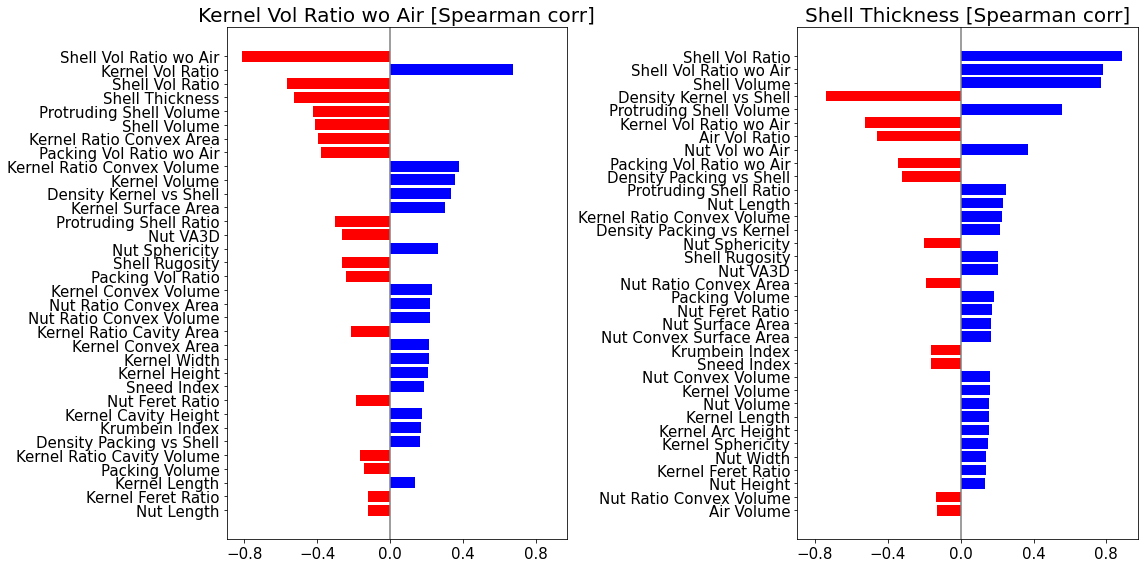

In [16]:
fs = 15
fig, ax = plt.subplots(1,2, figsize=(16,8), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

for idx,i in enumerate([49,26]):
    pval = spvalcorr[i-iniN]
    pval = np.hstack((pval[:i-2],pval[i-1:]))
    tags = np.hstack((labels.col_labels.iloc[iniN:i],labels.col_labels.iloc[i+1:endN]))
    
    vals = scorrstat[i-iniN]
    diff = vals - pcorrstat[i-iniN]
    
    vals = np.hstack((vals[:i-iniN],vals[i-iniN+1:]))
    diff = np.hstack((diff[:i-iniN],diff[i-iniN+1:]))
    
    bonferroni = 1e-3/len(vals)
    vals = vals[pval < bonferroni]
    diff = diff[pval < bonferroni]
    tags = tags[pval < bonferroni]
    
    print(vals.shape)
    
    sortarr = np.argsort(np.abs(vals))
    plus = np.where(vals[sortarr] > 0)[0]
    minus = np.where(vals[sortarr] < 0)[0]
    

    ax[idx].barh(plus, vals[sortarr][plus], color='b')
    ax[idx].barh(minus, vals[sortarr][minus], color='r')
    xlocator = ticker.MaxNLocator(steps=np.arange(2,11,2), nbins=5, min_n_ticks=3)
    ax[idx].xaxis.set_major_locator(xlocator)
    
    ax[idx].axvline(0, c='gray')
    ax[idx].set_yticks(range(len(vals)))
    ax[idx].set_yticklabels(tags[sortarr]);
    ax[idx].tick_params(labelsize=fs);
    ax[idx].set_title(labels.col_labels.iloc[i] + ' [Spearman corr]', fontsize=20)
    #ax[idx].set_aspect('equal')
fig.tight_layout();

filename = dst + labels.col_labels.iloc[i].lower().replace(' ','_') + '_hbar_correlation'
filename = dst + 'combination_hbar_correlation'
print(filename)
plt.savefig(filename + '.pdf', dpi=200, format='pdf', bbox_inches='tight')
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

../../writing/walnut_figs/shell_thickness_correlation_2x4


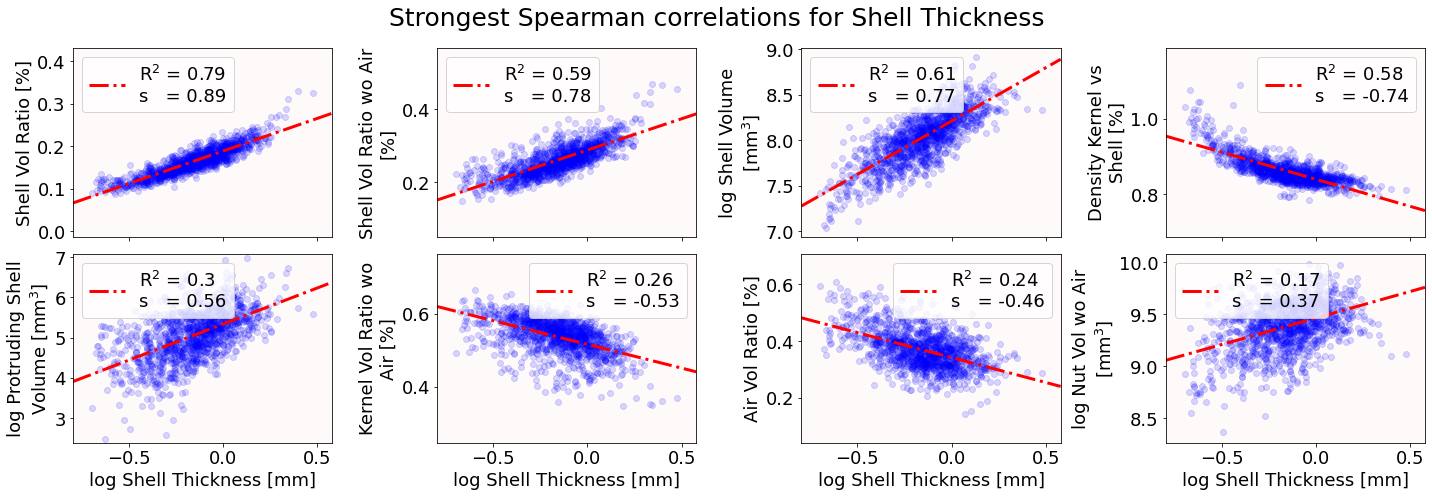

In [39]:
fs = 18
fig, ax = plt.subplots(2,4, figsize=(20,7), sharex=True)
ax = np.atleast_1d(ax).ravel()

i = 26
if 'mm' in labels.col_units.iloc[i+iniN]:
    TRAIT_I = np.log(df.iloc[:,i].values)
    xlabel = 'log ' + labels.col_labels.iloc[i] + labels.col_units.iloc[i]
else:
    TRAIT_I = df.iloc[:,i].values
    xlabel = labels.col_labels.iloc[i] + labels.col_units.iloc[i]

xrange = np.linspace(np.min(TRAIT_I)-0.1, np.max(TRAIT_I)+0.1, 100)
args = np.argsort(np.abs(scorrstat[i-iniN]))[::-1][1:]

for idx in range(len(ax)):
    j = args[idx]
    s = scorrstat[i-iniN,j]
    
    if 'mm' in labels.col_units.iloc[j+iniN]:
        nonzero = np.nonzero(df.iloc[:,j+iniN].values)[0]
        if len(nonzero) == len(df):
            trait_i = TRAIT_I.copy()
            trait_j = np.log(df.iloc[:,j+iniN].values)
        else:
            trait_i = df.iloc[nonzero, i].values
            trait_j = np.log(df.iloc[nonzero,j+iniN].values)

        ylabel = 'log ' + labels.col_labels.iloc[j+iniN] + labels.col_units.iloc[j+iniN]
        r,_ = stats.pearsonr(trait_i, trait_j)
    else:
        trait_i = TRAIT_I.copy()
        trait_j = df.iloc[:,j+iniN].values
        ylabel = labels.col_labels.iloc[j+iniN] + labels.col_units.iloc[j+iniN]
    
    r = pcorrstat[i-2,j]
    
    ax[idx].set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
    ax[idx].set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
    ax[idx].set_facecolor('snow')
    ax[idx].tick_params(labelsize=fs)

    new_series = P.Polynomial.fit(trait_i,trait_j, deg=1, full=False)
    foo = new_series.convert().coef
    r2 = r2_score(trait_j, new_series(trait_i))
    #axlabel = 'm = {:.2}\nb = {:.2}\ns = {:.2}'.format(foo[1], foo[0], s)
    axlabel = 'R$^2$ = {:.2}\ns   = {:.2}'.format(r2,s)
    #bar = ax[idx].axline(xy1=(0,foo[0]), slope=foo[1], color='r', label=axlabel, ls='-.', lw=3)
    ax[idx].plot(xrange, new_series(xrange), color='r', label=axlabel, ls='-.', lw=3)

    ax[idx].scatter(trait_i, trait_j, color='b', alpha=0.15)
    
    ax[idx].set_ylabel(textwrap.fill(ylabel,22), fontsize=fs);
    if foo[1] > 0:
        ax[idx].legend(loc='upper left', fontsize=fs)
    else:
        ax[idx].legend(loc='upper right', fontsize=fs)
        
for idx in range(len(ax)-4,len(ax)):
    ax[idx].set_xlabel(xlabel, fontsize=fs);

fig.suptitle('Strongest Spearman correlations for ' + labels.col_labels.iloc[i], fontsize=25)
fig.tight_layout()
filename = dst + labels.col_labels.iloc[i].lower().replace(' ','_') + '_correlation_2x4'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

../hpcc/traditional/results/individual_tissue_volume_relationship


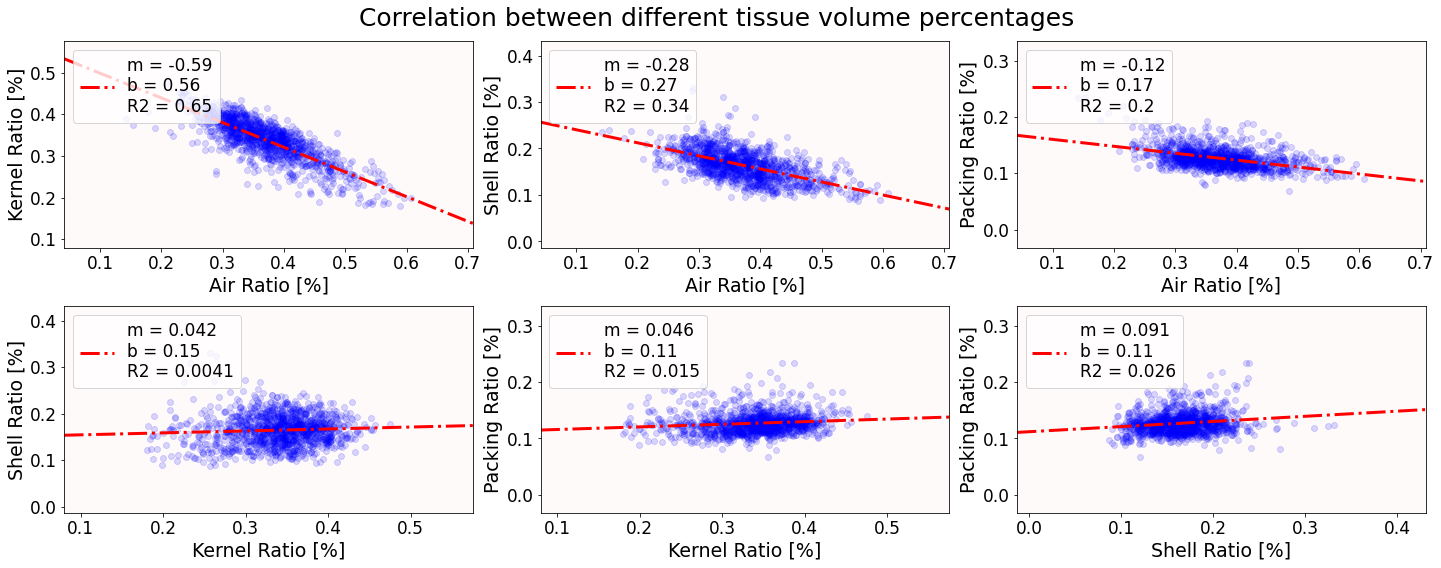

In [30]:
fs = 17
fig, ax = plt.subplots(2,3, figsize=(20,8))
ax = np.atleast_1d(ax).ravel()

idx = 0
for i in range(21,25):
    trait_i = (df.iloc[:,i].values)
    for j in range(i+1, 25):
        trait_j = (df.iloc[:,j].values)
        r,p = stats.pearsonr(trait_i, trait_j)

        ax[idx].set_xlim((np.min(trait_i)-0.1, np.max(trait_i)+0.1))
        ax[idx].set_ylim((np.min(trait_j)-0.1, np.max(trait_j)+0.1))
        ax[idx].set_facecolor('snow')
        ax[idx].tick_params(labelsize=fs)

        new_series = P.Polynomial.fit(trait_i,trait_j, deg=1, full=False)
        foo = new_series.convert().coef
        r2 = r2_score(trait_j, new_series(trait_i))
        axlabel = 'm = {:.2}\nb = {:.2}\nR2 = {:.2}'.format(foo[1], foo[0], r2)
        bar = ax[idx].axline(xy1=(0,foo[0]), slope=foo[1], color='r', label=axlabel, ls='-.', lw=3)

        ax[idx].scatter(trait_i, trait_j, color='b', alpha=0.15)
        ax[idx].set_ylabel(labels.col_labels.iloc[j] + labels.col_units.iloc[j], fontsize=fs+2);
        ax[idx].set_xlabel(labels.col_labels.iloc[i] + labels.col_units.iloc[i], fontsize=fs+2);
        ax[idx].legend(loc='upper left', fontsize=fs)
        idx += 1

#for idx in range(10,len(ax)):
#    ax[idx].set_xlabel('log ' + col_labels[i] + col_units[i], fontsize=fs+2);

fig.suptitle('Correlation between different tissue volume percentages', fontsize=25)
fig.tight_layout()
filename = dst + 'individual_tissue_volume_relationship'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')

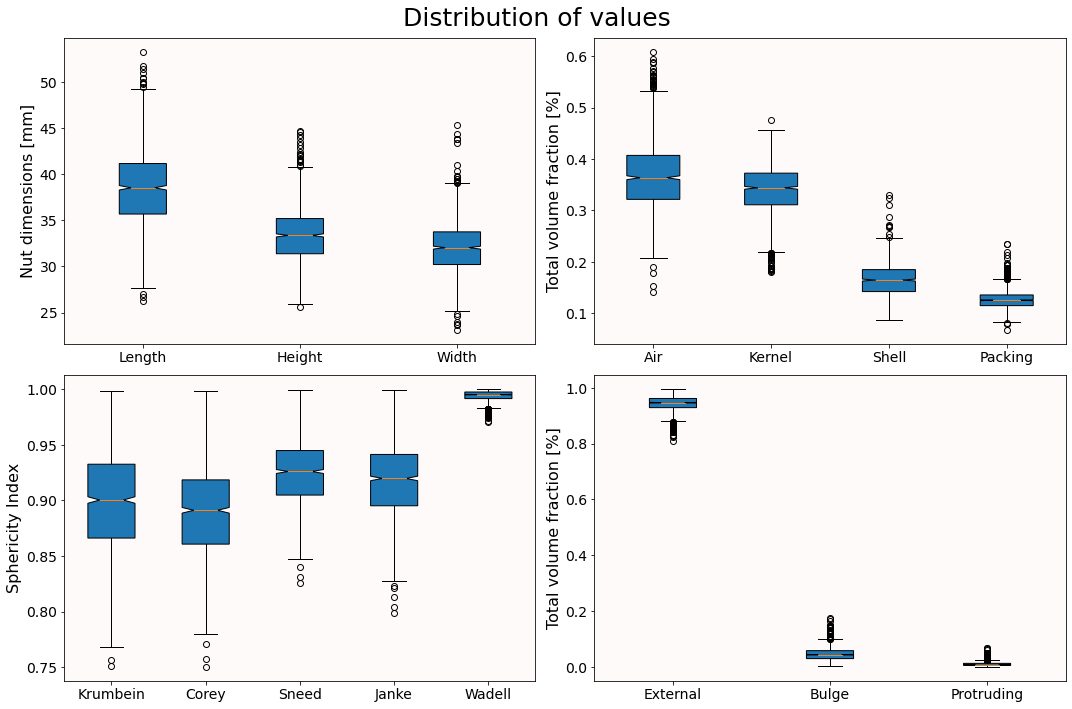

In [40]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = np.atleast_1d(ax).ravel()

idx=0
ss=np.s_[2:5]; labels = [(s.split(' ')[1]) for s in col_labels[ss]]
ax[idx].boxplot(df.iloc[:,ss].values, notch=True, vert=True, patch_artist=True, labels=labels);
ax[idx].set_ylabel('Nut dimensions [mm]', fontsize=fs+2)
idx+=1; 

ss=np.s_[26:30]; labels = [(s.split(' ')[0]) for s in col_labels[ss]]
ax[idx].boxplot(df.iloc[:,ss].values, notch=True, vert=True, patch_artist=True, labels=labels);
ax[idx].set_ylabel('Total volume fraction [%]', fontsize=fs+2)
idx+=1; 

ss=np.s_[17:22]; labels = [(s.split(' ')[0]) for s in col_labels[ss]]
ax[idx].boxplot(df.iloc[:,ss].values, vert=True, notch=True, patch_artist=True, labels=labels);
ax[idx].set_ylabel('Sphericity Index', fontsize=fs+2)
idx+=1; 

ss=np.s_[35:38]; labels = [(s.split(' ')[0]) for s in col_labels[ss]]
ax[idx].boxplot(df.iloc[:,ss].values, notch=True, vert=True, patch_artist=True, labels=labels);
ax[idx].set_ylabel('Total volume fraction [%]', fontsize=fs+2)
idx+=1; 

for idx in range(len(ax)):
    ax[idx].set_facecolor('snow')
    ax[idx].tick_params(labelsize=fs)
    
fig.suptitle('Distribution of values', fontsize=25)
fig.tight_layout()

filename = dst + 'nutdim_volratio_sphericty_box_plots'
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')

# Correlation

In [28]:
offset = 3
qtraits = np.array([21,22,23,24] + [49,51,50] + [44])
ptraits = qtraits.copy()
filename = src + 'vol_ratios_spearman_correlation_pvals_'+perbasis+'.csv' 

if os.path.isfile(filename):
    
    foo = np.loadtxt(filename, delimiter=',')
    scorrstat = foo[:len(qtraits)]
    spvalcorr = foo[len(qtraits):]
    
else:
    import resampling

    scorrstat = np.ones((len(qtraits), len(ptraits)))
    spvalcorr = np.zeros_like(scorrstat)

    feats = df.iloc[:, offset:].values.copy()

    for i in range(len(qtraits)):
        for j in range(i):
            x = feats[:,qtraits[i] - offset]
            y = feats[:,ptraits[j] - offset]
            sstat, spval = stats.spearmanr(x,y)
            scorrstat[i,j] = sstat
            spvalcorr[i,j] = spval

            if len(y) < 500:
                def statistic(x):  # permute only `x`
                    return stats.spearmanr(x, y).correlation
                
                spval = resampling.permutation_test((x,), statistic, permutation_type='pairings')
                spvalcorr[i,j] = spval.pvalue

    np.savetxt(filename, np.vstack((scorrstat, spvalcorr)), delimiter=',')

In [29]:
corr = scorrstat.copy()
pval = spvalcorr.copy()

for i in range(corr.shape[0]-1):
    for j in range(i+1,corr.shape[1]):
        corr[i,j] = 0
        pval[i,j] = 1
corr.shape

pval_ = np.zeros_like(pval).astype(int)
for i in range(pval.shape[0]):
    for j in range(pval.shape[1]):
        if (pval[i,j] == 0) or (pval[i,j] > 1e-2):
            pval_[i,j] = 0
        elif (pval[i,j] <= 1e-2) and (pval[i,j] > 1e-3):
            pval_[i,j] = 1
        elif (pval[i,j] <= 1e-3) and (pval[i,j] > 1e-4):
            pval_[i,j] = 2
        else:
            pval_[i,j] = 3
pval_

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0],
       [3, 3, 3, 0, 0, 0, 0, 0],
       [3, 3, 3, 3, 0, 0, 0, 0],
       [1, 3, 3, 3, 3, 0, 0, 0],
       [3, 3, 3, 3, 3, 3, 0, 0],
       [3, 2, 3, 0, 3, 3, 3, 0]])

../../writing/walnut_figs/vol_ratios_correlation_individual


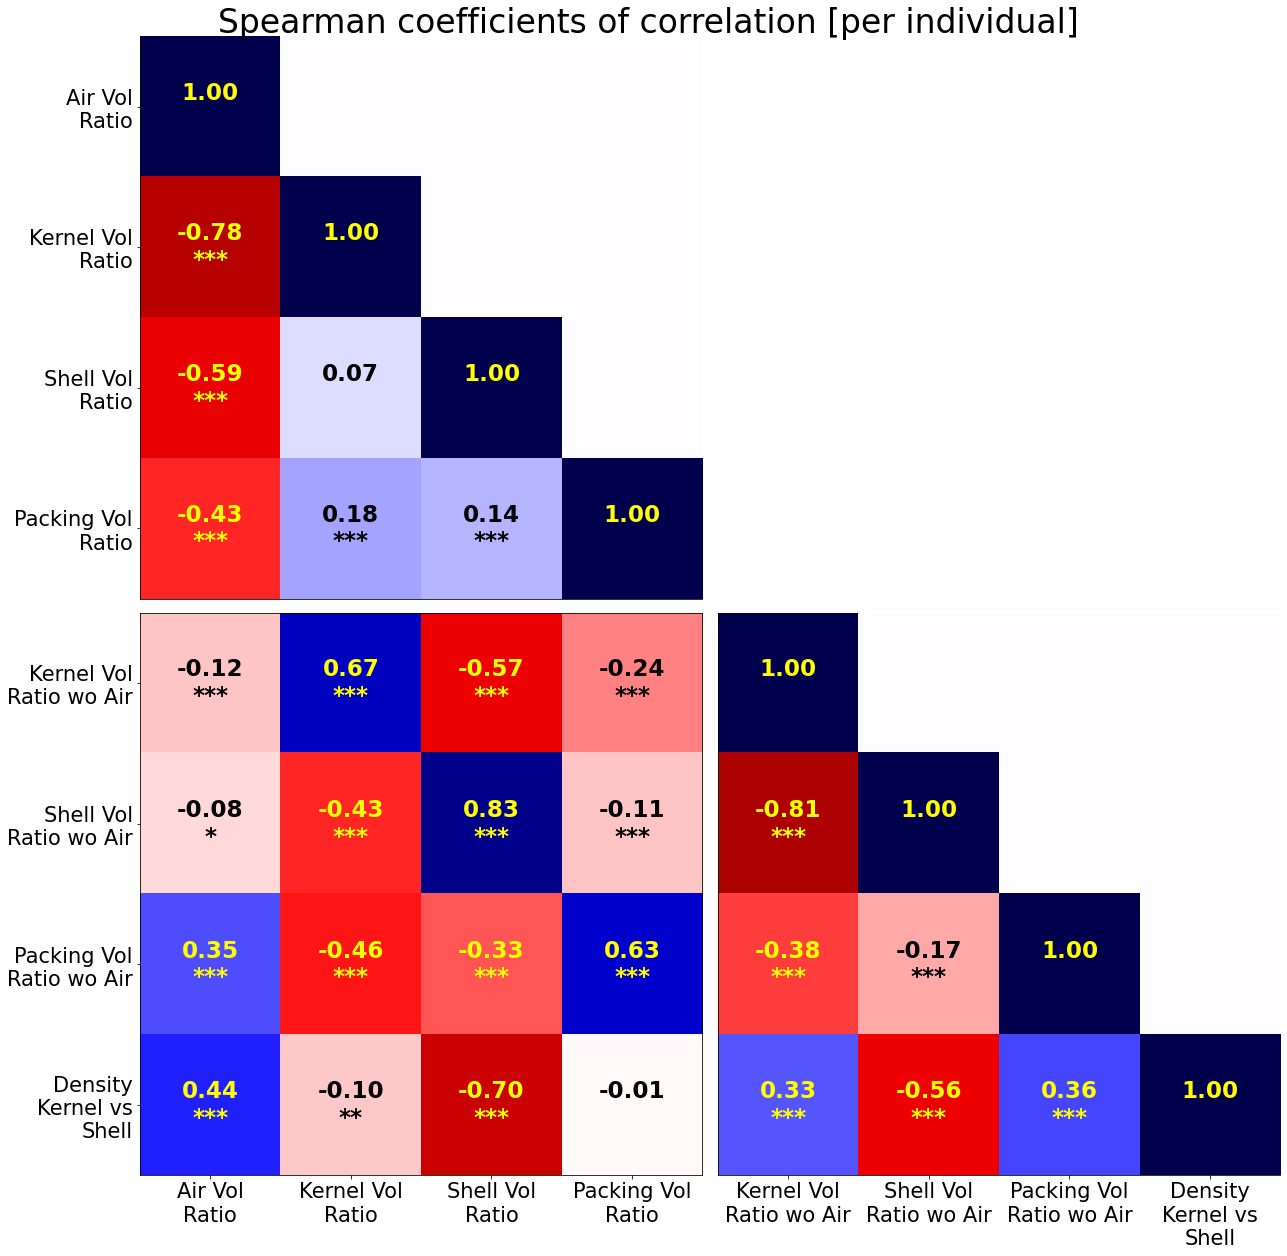

In [34]:
fs = 23
tw = 12
pt = 0.
fw = 'bold'
sig = ['', '*', '**', '***']
fig, ax = plt.subplots(2,2,figsize=(18,17.75))
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(corr[:4,:4], cmap='seismic_r', vmin=-1, vmax=1)
ax[2].imshow(corr[4:, :4], cmap='seismic_r', vmin=-1, vmax=1)
ax[3].imshow(corr[4:, 4:], cmap='seismic_r', vmin=-1, vmax=1)

for i in range(len(ax)):
    ax[i].set_xticks(np.arange(4))
    ax[i].set_yticks(np.arange(4))
    ax[i].tick_params(labelsize=fs-2)

ax[0].set_yticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][:4]])
ax[2].set_yticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][4:]])

ax[2].set_xticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][:4]])
ax[3].set_xticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][4:]])

ax[0].get_xaxis().set_ticks([])
ax[3].get_yaxis().set_ticks([])

for i in [0,3]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

for i in range(4):
    for j in range(i+1):
        if np.abs(corr[i,j]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[0].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i,j],2)), sig[pval_[i,j]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)
for i in range(4):
    for j in range(4):
        if np.abs(corr[i+4,j]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[2].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i+4,j],2)), sig[pval_[i+4,j]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)

for i in range(4):
    for j in range(i+1):
        if np.abs(corr[i+4,j+4]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[3].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i+4,j+4],2)), sig[pval_[i+4,j+4]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)
        
fig.delaxes(ax[1])

fig.suptitle("Spearman coefficients of correlation [per "+perbasis+"]", fontsize=fs+10)

fig.tight_layout()

filename = dst + 'vol_ratios_correlation_' +perbasis
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', dpi=100, format='pdf', bbox_inches='tight')

In [34]:
dropsubset = [0,1,2,4,7,8,9] + [12,13] + [22] + [26,27,28,30,31,34,35]

../../writing/walnut_figs/spearman_correlation


<Figure size 1296x1296 with 0 Axes>

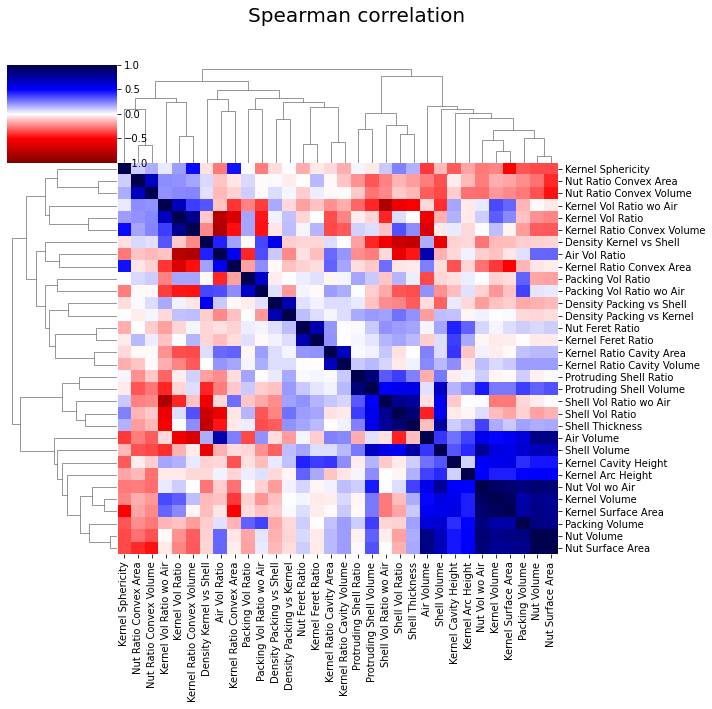

In [35]:
vmin, vmax = -1,1
cmap = 'seismic_r'
foo = pd.DataFrame(scorrstat, columns=labels.col_labels.iloc[iniN:endN].values, 
                   index=labels.col_labels.iloc[iniN:endN].values)
foo = foo.drop(columns=foo.columns[dropsubset], index=foo.index[dropsubset])

plt.figure(figsize=(18,18));
sns.clustermap(foo, vmax=vmax, vmin=vmin, cmap=cmap);
plt.subplots_adjust(top=0.9)
plt.suptitle('Spearman correlation', fontsize=20);

filename = dst + 'spearman_correlation'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', dpi=200, format='pdf', bbox_inches='tight')

../hpcc/traditional/results/pearson_correlation


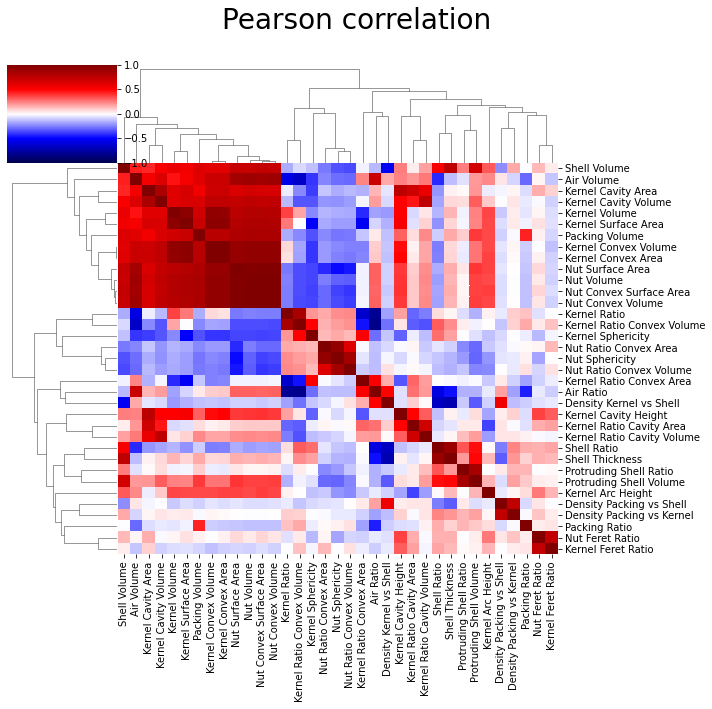

In [33]:
vmin, vmax = -1,1
cmap = 'seismic'
foo = pd.DataFrame(pcorrstat, columns=labels.col_labels.iloc[iniN:endN].values, 
                   index=labels.col_labels.iloc[iniN:endN].values)
foo = foo.drop(columns=foo.columns[dropsubset], index=foo.index[dropsubset])

#plt.figure(figsize=(18,18));
sns.clustermap(foo, vmax=vmax, vmin=vmin, cmap=cmap);
plt.subplots_adjust(top=0.9)
plt.suptitle('Pearson correlation', fontsize=28);

filename = dst + 'pearson_correlation'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', dpi=200, format='pdf', bbox_inches='tight')

# Link to categorical traits from Pat Brown

In [34]:
fs = 15
marker = ['o', 'v','*','^', 's', '<', 'X', '>', 'p', '8', 'h', 'H', 'D', 'd', 'P']
#col_wong = ['#e69f00', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#f0e442', '#56b4e9']
col_wong = ['#d81b60', '#1e88e5', '#ffc107', '#004d40', '#56e495']
col_wong += col_wong

cattraitnames = df.columns[endN:].values[[12,4,1,3,7,6,11,0,2]]

for i in range(len(cattraitnames)):
    print(i, cattraitnames[i], sep='\t')

0	EaseOfRemoval
1	ShellStrength
2	ShellTexture
3	SEAL
4	KernelFill
5	PackingTissue
6	Plumpness
7	ShellIntegrity
8	ShellColor


# PCA

In [35]:
imgfeats = df.iloc[:,iniN:endN].values.copy()
scaler = prep.StandardScaler().fit(imgfeats)
imgfeats = scaler.transform(imgfeats)
print(imgfeats.shape)

(1264, 45)


In [36]:
pca = decomp.PCA(n_components=2, svd_solver='full')
pca.fit(imgfeats)

print(100*pca.explained_variance_ratio_[:10])
print(pca.singular_values_[:10])
print(100*np.cumsum(pca.explained_variance_ratio_)[:10])

redux = pca.transform(imgfeats)
print(redux.shape)

[36.16292727 11.66860816]
[143.42061578  81.46842529]
[36.16292727 47.83153543]
(1264, 2)


../hpcc/traditional/results/PCA_trait_scatter


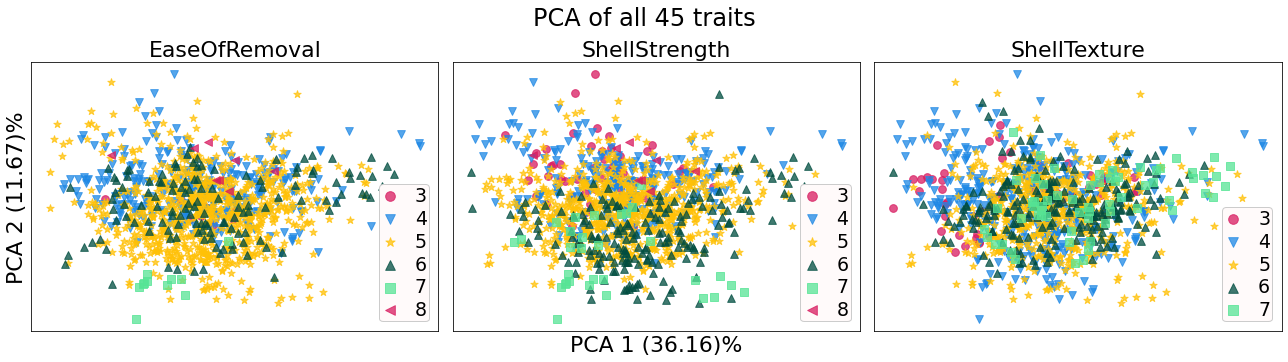

In [37]:
fs = 22
fig, ax = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0

for idx in range(len(ax)):
    cattraitname = cattraitnames[idx]
    cattrait = np.sort(pd.unique(df[cattraitname]))[1:]
    cattrait = cattrait.astype(int)
    
    for k in range(len(cattrait)):
        mask = df[cattraitname] == cattrait[k]
        ax[idx].scatter(redux[mask,0],
                        redux[mask,1],
                        color=col_wong[k], marker=marker[k], s=60, alpha=.75, label=cattrait[k])
    ax[idx].legend(fontsize=fs-3, markerscale=1.25, borderpad=0.1, 
                   labelspacing=0.2, handlelength=1,framealpha=1, facecolor='snow');
    ax[idx].set_title(cattraitname, fontsize=fs);
    
for i in range(len(ax)):
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    for spine in ax[i].spines.values():
        spine.set_visible(True)
    ax[i].set_aspect('equal')

ax[1].set_xlabel('PCA 1 ({:.2f})%'.format(pca.explained_variance_ratio_[0]*100), fontsize=fs)
ax[0].set_ylabel('PCA 2 ({:.2f})%'.format(pca.explained_variance_ratio_[1]*100), fontsize=fs);

fig.suptitle('PCA of all {} traits'.format(imgfeats.shape[1]), fontsize = fs+2)
fig.tight_layout();

filename = dst + 'PCA_trait_scatter'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

../../webpage/walnuts/figs/PCA_loadings_h


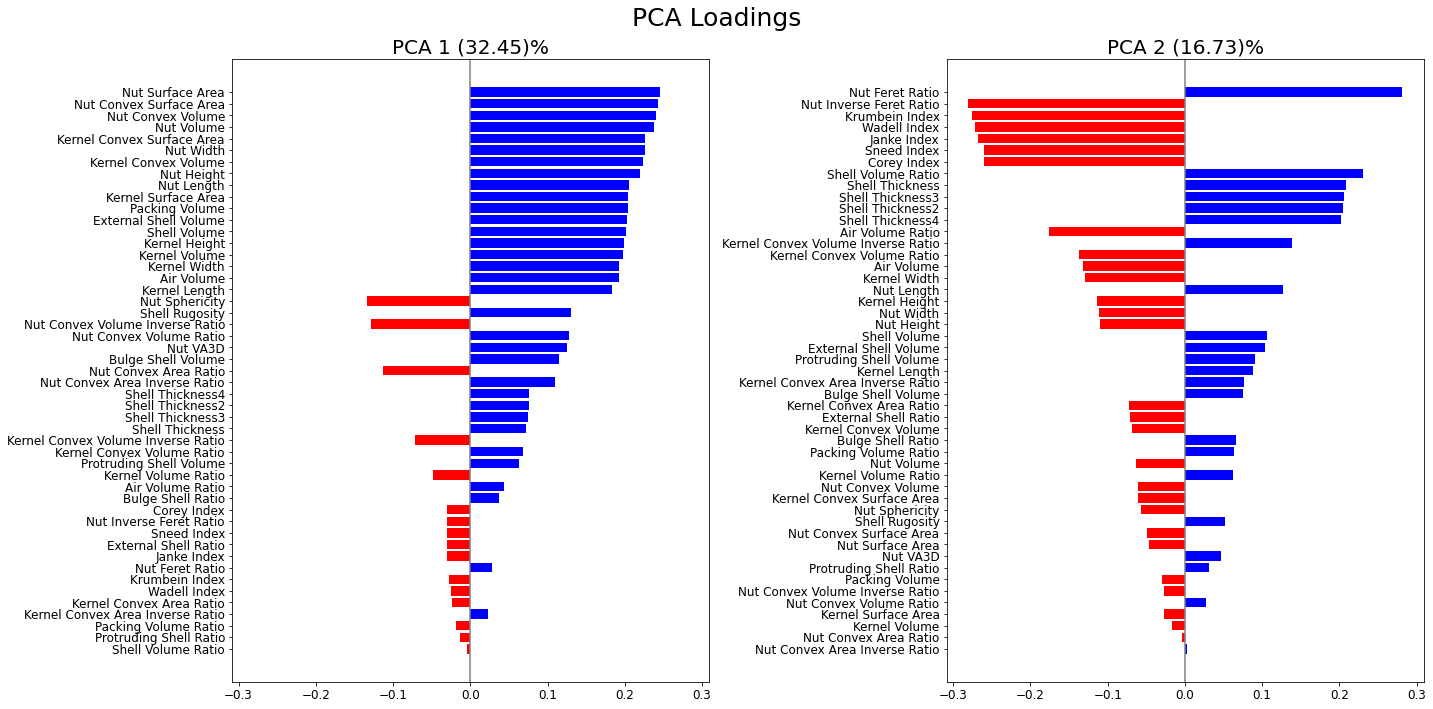

In [119]:
fs = 12
fig, ax = plt.subplots(1,2, figsize=(20,10), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

idx = 0
#ax[idx].set_ylabel('PCA Loadings', fontsize=fs)

for idx in range(len(ax)):
    sortarr = np.argsort(np.abs(pca.components_[idx]))
    plus = np.where(pca.components_[idx][sortarr] > 0)[0]
    minus = np.where(pca.components_[idx][sortarr] < 0)[0]

    ax[idx].barh(plus, pca.components_[idx][sortarr][plus], color='b')
    ax[idx].barh(minus, pca.components_[idx][sortarr][minus], color='r')
    ax[idx].axvline(0, c='gray')
    ax[idx].set_yticks(range(len(pca.components_[idx])))
    ax[idx].set_yticklabels(scol_labels[sortarr+2]);
    ax[idx].tick_params('x', labelrotation=0, labelsize=fs);
    ax[idx].tick_params('y', labelsize=fs);
    ax[idx].set_title('PCA {} ({:.2f})%'.format(idx+1, pca.explained_variance_ratio_[idx]*100), fontsize=20)

fig.suptitle('PCA Loadings', fontsize=25)
fig.tight_layout();

filename = dst + 'PCA_loadings_h'
print(filename)
plt.savefig(filename + '.jpg', dpi=135, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# KPCA

In [74]:
kpca = decomp.KernelPCA(n_components=2, 
                        kernel='rbf', 
                        gamma = 0.05, 
                        degree = 3,
                        coef0 = 1,
                        fit_inverse_transform=False, eigen_solver='dense')
kredux = kpca.fit_transform(imgfeats)
print(kredux.shape)

(1264, 2)


../hpcc/traditional/results/KPCA_rbf_trait_scatter


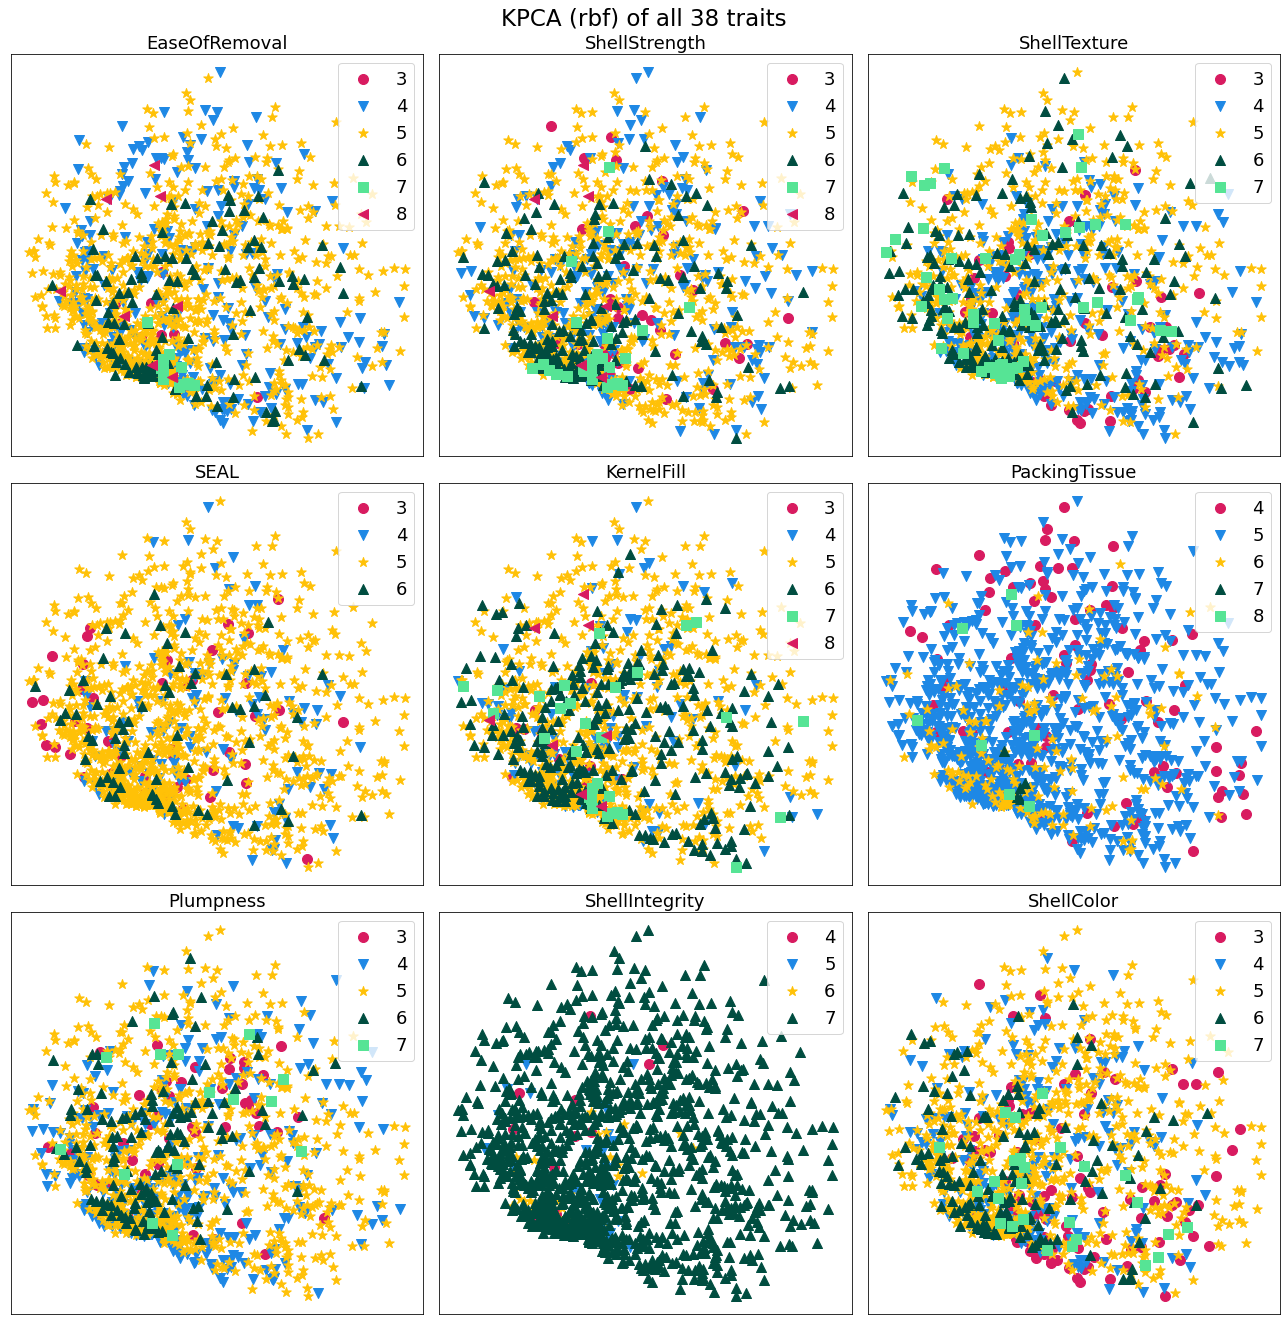

In [75]:
fs = 18
fig, ax = plt.subplots(3,3, figsize=(18,18.5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0

for idx in range(len(ax)):
    cattraitname = cattraitnames[idx]
    cattrait = np.sort(pd.unique(df[cattraitname]))[1:]
    cattrait = cattrait.astype(int)
    
    for k in range(len(cattrait)):
        mask = df[cattraitname] == cattrait[k]
        ax[idx].scatter(kredux[mask,0],
                        kredux[mask,1],
                        color=col_wong[k], marker=marker[k], s=100, alpha=1, label=cattrait[k])
    ax[idx].legend(fontsize=fs);
    ax[idx].set_title(cattraitname, fontsize=fs);

for i in range(len(ax)):
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    for spine in ax[i].spines.values():
        spine.set_visible(True)
    ax[i].set_aspect('equal')

fig.suptitle('KPCA (rbf) of all 38 traits', fontsize = fs+5, y=.99)
fig.tight_layout();

filename = dst + 'KPCA_rbf_trait_scatter'
print(filename)
#plt.savefig(filename + '.jpg', dpi=135, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# Isomap

In [76]:
iso = mfold.Isomap(n_components=2, n_neighbors=16)
iredux = iso.fit_transform(imgfeats)
print(iredux.shape)

(1264, 2)


../hpcc/traditional/results/isomap_trait_scatter


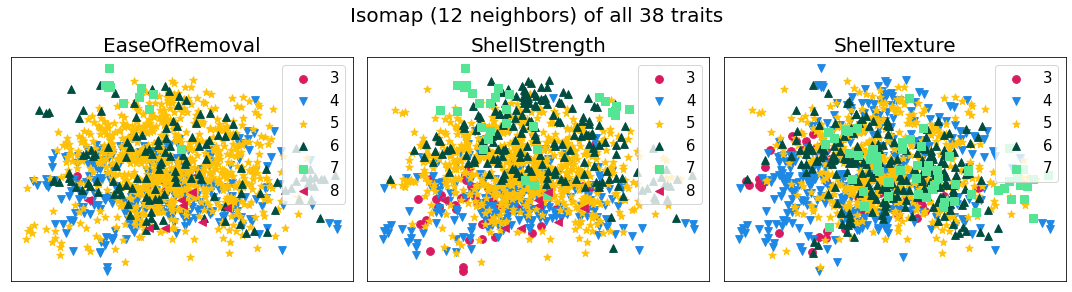

In [77]:
fs = 15
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0

for idx in range(len(ax)):
    cattraitname = cattraitnames[idx]
    cattrait = np.sort(pd.unique(df[cattraitname]))[1:]
    cattrait = cattrait.astype(int)
    
    for k in range(len(cattrait)):
        mask = df[cattraitname] == cattrait[k]
        ax[idx].scatter(iredux[mask,0],
                        iredux[mask,1],
                        color=col_wong[k], marker=marker[k], s=60, alpha=1, label=cattrait[k])
    ax[idx].legend(fontsize=fs);
    ax[idx].set_title(cattraitname, fontsize=20);

for i in range(len(ax)):
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    for spine in ax[i].spines.values():
        spine.set_visible(True)
    ax[i].set_aspect('equal')

fig.suptitle('Isomap (12 neighbors) of all 38 traits', fontsize = fs+5, y=.91)
fig.tight_layout();

filename = dst + 'isomap_trait_scatter'
print(filename)
plt.savefig(filename + '.jpg', dpi=135, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# LLE

(1264, 2)
../hpcc/traditional/results/lle_trait_scatter


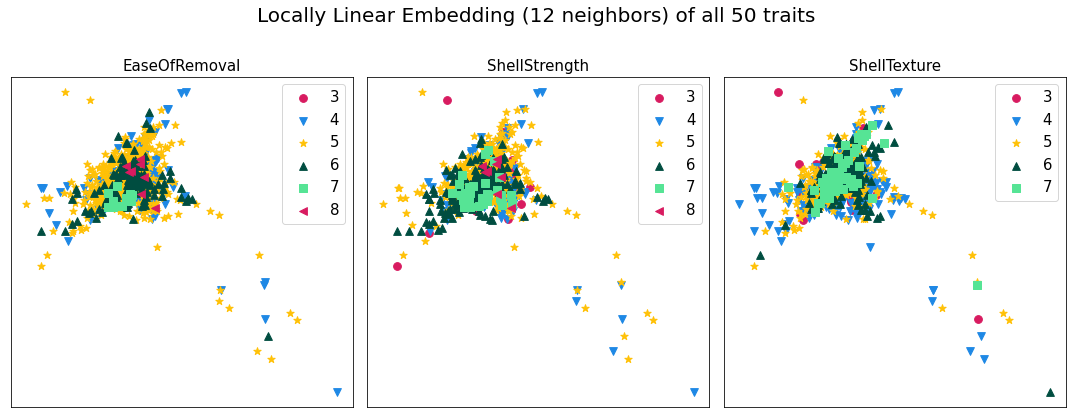

In [78]:
lle = mfold.LocallyLinearEmbedding(n_components=2, n_neighbors=12)
lredux = lle.fit_transform(imgfeats)
print(lredux.shape)

fs = 15
fig, ax = plt.subplots(1,3, figsize=(15,6.5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0

for idx in range(len(ax)):
    cattraitname = cattraitnames[idx]
    cattrait = np.sort(pd.unique(df[cattraitname]))[1:]
    cattrait = cattrait.astype(int)
    
    for k in range(len(cattrait)):
        mask = df[cattraitname] == cattrait[k]
        ax[idx].scatter(lredux[mask,0],
                        lredux[mask,1],
                        color=col_wong[k], marker=marker[k], s=60, alpha=1, label=cattrait[k])
    ax[idx].legend(fontsize=fs);
    ax[idx].set_title(cattraitname, fontsize=fs);

for i in range(len(ax)):
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    for spine in ax[i].spines.values():
        spine.set_visible(True)
    ax[i].set_aspect('equal')

fig.suptitle('Locally Linear Embedding (12 neighbors) of all 50 traits', fontsize = fs+5, y=.97)
fig.tight_layout();

filename = dst + 'lle_trait_scatter'
print(filename)
#plt.savefig(filename + '.jpg', dpi=135, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# Spectral Embedding

(1264, 2)
../hpcc/traditional/results/se_trait_scatter


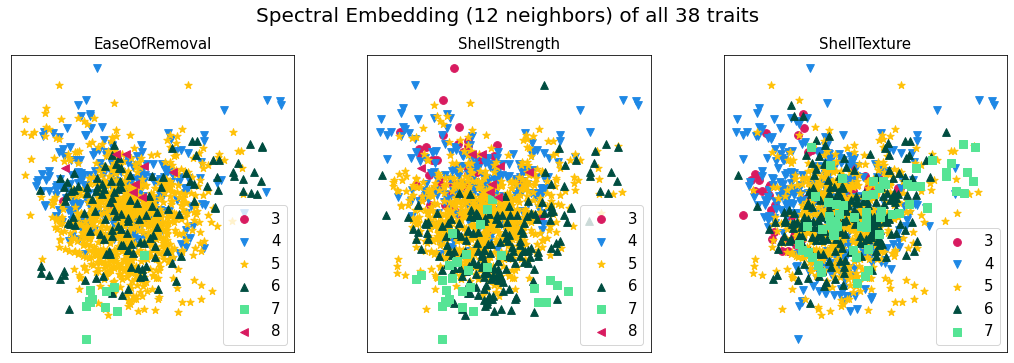

In [79]:
se = mfold.SpectralEmbedding(n_components=2,
                             affinity = 'rbf', #nearest_neighbors,
                             gamma = 0.005,
                             n_neighbors = 22)

sredux = se.fit_transform(imgfeats)
print(lredux.shape)

fs = 15
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0

for idx in range(len(ax)):
    cattraitname = cattraitnames[idx]
    cattrait = np.sort(pd.unique(df[cattraitname]))[1:]
    cattrait = cattrait.astype(int)
    
    for k in range(len(cattrait)):
        mask = df[cattraitname] == cattrait[k]
        ax[idx].scatter(sredux[mask,0],
                        sredux[mask,1],
                        color=col_wong[k], marker=marker[k], s=60, alpha=1, label=cattrait[k])
    ax[idx].legend(fontsize=fs);
    ax[idx].set_title(cattraitname, fontsize=fs);

for i in range(len(ax)):
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    for spine in ax[i].spines.values():
        spine.set_visible(True)
    ax[i].set_aspect('equal')

fig.suptitle('Spectral Embedding (12 neighbors) of all 38 traits', fontsize = fs+5, y=.99)
fig.tight_layout();

filename = dst + 'se_trait_scatter'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# MDS

In [193]:
mds = mfold.MDS(n_components=2, metric=True,
                n_init = 10, dissimilarity='euclidean')

mredux = mds.fit_transform(imgfeats)

../../webpage/walnuts/figs/mds_trait_scatter


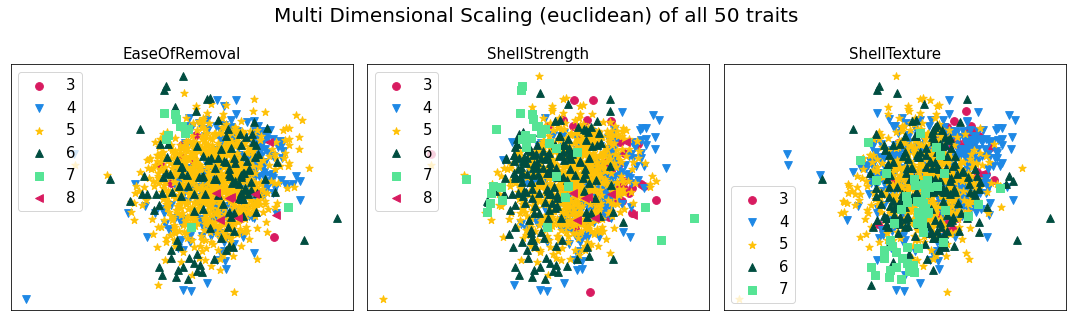

In [197]:
fs = 15
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0

for idx in range(len(ax)):
    cattraitname = cattraitnames[idx]
    cattrait = np.sort(pd.unique(df[cattraitname]))[1:]
    cattrait = cattrait.astype(int)
    
    for k in range(len(cattrait)):
        mask = df[cattraitname] == cattrait[k]
        ax[idx].scatter(mredux[mask,0],
                        mredux[mask,1],
                        color=col_wong[k], marker=marker[k], s=60, alpha=1, label=cattrait[k])
    ax[idx].legend(fontsize=fs);
    ax[idx].set_title(cattraitname, fontsize=fs);

for i in range(len(ax)):
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    for spine in ax[i].spines.values():
        spine.set_visible(True)
    ax[i].set_aspect('equal')

fig.suptitle('Multi Dimensional Scaling (euclidean) of all 50 traits', fontsize = fs+5, y=.96)
fig.tight_layout();

filename = dst + 'mds_trait_scatter'
print(filename)
plt.savefig(filename + '.jpg', dpi=135, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# t-SNE

In [345]:
tredux = mfold.TSNE(n_components=2, perplexity=12, early_exaggeration=20).fit_transform(imgfeats)

../../writing/walnut_figs/tsne_trait_scatter


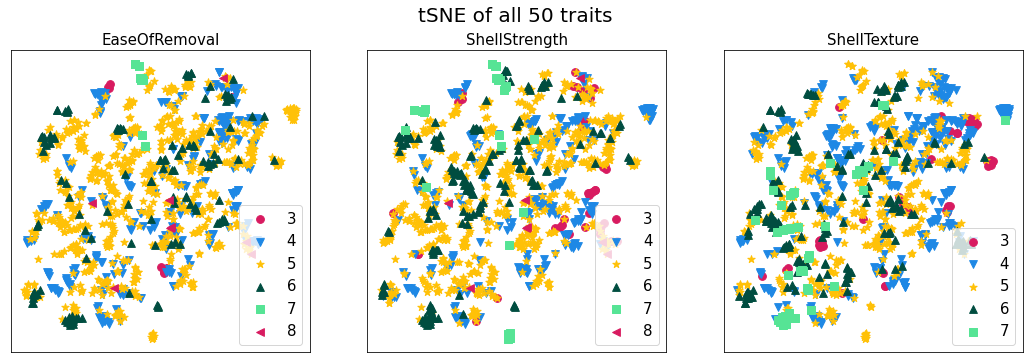

In [346]:
fs = 15
fig, ax = plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

idx = 0

for idx in range(len(ax)):
    cattraitname = cattraitnames[idx]
    cattrait = np.sort(pd.unique(df[cattraitname]))[1:]
    cattrait = cattrait.astype(int)
    
    for k in range(len(cattrait)):
        mask = df[cattraitname] == cattrait[k]
        ax[idx].scatter(tredux[mask,0],
                        tredux[mask,1],
                        color=col_wong[k], marker=marker[k], s=60, alpha=1, label=cattrait[k])
    ax[idx].legend(fontsize=fs);
    ax[idx].set_title(cattraitname, fontsize=fs);

for i in range(len(ax)):
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    for spine in ax[i].spines.values():
        spine.set_visible(True)
    ax[i].set_aspect('equal')

fig.suptitle('tSNE of all 50 traits', fontsize = fs+5, y=.99)
fig.tight_layout();

filename = dst + 'tsne_trait_scatter'
print(filename)
#plt.savefig(filename + '.jpg', dpi=135, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})